## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

Positive reviews count:  12500
Negative reviews count:  12500


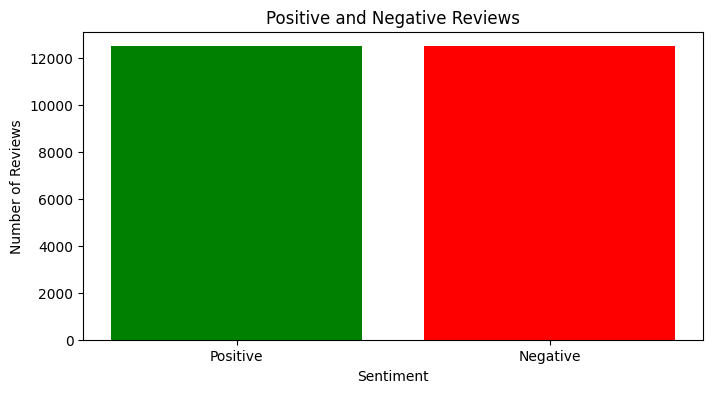

                                              ReviewText
0      bromwell high is a cartoon comedy . it ran at ...
1      story of a man who has unnatural feelings for ...
2      homelessness  or houselessness as george carli...
3      airport    starts as a brand new luxury    pla...
4      brilliant over  acting by lesley ann warren . ...
...                                                  ...
24995  i saw  descent  last night at the stockholm fi...
24996  a christmas together actually came before my t...
24997  some films that you pick up for a pound turn o...
24998  working  class romantic drama from director ma...
24999  this is one of the dumbest films  i  ve ever s...

[25000 rows x 1 columns]


In [68]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)

reviews.columns = ['ReviewText']
labels.columns = ['Label']

Y = (labels['Label']=='positive').astype(np.int_)


positive_reviews_count = Y.sum()
negative_reviews_count = Y.size - positive_reviews_count

print("Positive reviews count: ", positive_reviews_count)
print("Negative reviews count: ", negative_reviews_count)

plt.figure(figsize=(8, 4))
plt.bar(['Positive', 'Negative'], [positive_reviews_count, negative_reviews_count], color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Positive and Negative Reviews')
plt.show()

print(reviews)

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

**(d)** Test your sentiment-classifier on the test set.

**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [69]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
              "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
              "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
              "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
              "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
              "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
              "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
              "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
              "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
              "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]


Cleaning text

In [46]:
cleaned_reviews = []
pattern = r'\b(' + '|'.join(stop_words) + r')\b'
for review in reviews['ReviewText']:
    cleaned_text = re.sub(pattern, '', review, flags=re.IGNORECASE)
    cleaned_reviews.append(cleaned_text)

Train-Test-Validation Split

['aaron' 'abandon' 'abandoned' ... 'zoom' 'zorro' 'zu']
br           71733
movie        31011
film         28125
one          18915
like         14147
             ...  
gerald          21
nuance          21
supporter       21
geoffrey        21
coal            21
Length: 10000, dtype: int64


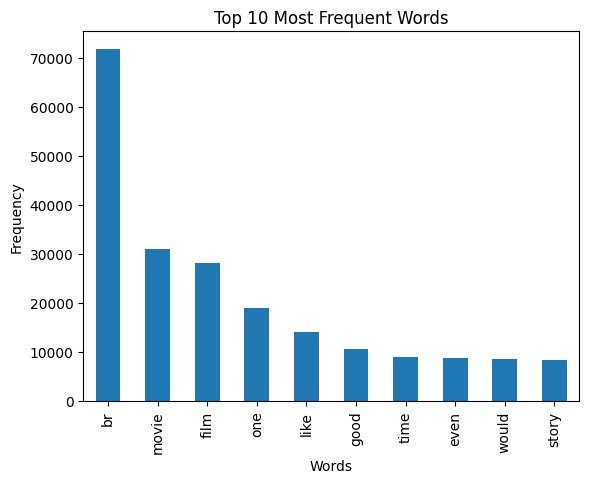

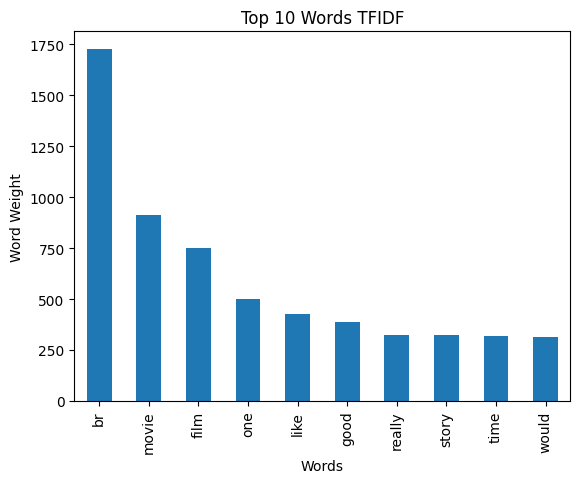

In [73]:
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(reviews['ReviewText'], Y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

vectorizer = CountVectorizer(max_features=10000, stop_words=stop_words)
count_matrix = vectorizer.fit_transform(X_train_temp)
count_array = count_matrix.toarray()

df_count_vectorizer = pd.DataFrame(data=count_array, columns = vectorizer.get_feature_names_out())
print(vectorizer.get_feature_names_out())

word_frequencies = df_count_vectorizer.sum(axis=0).sort_values(ascending=False)
print(word_frequencies)

word_frequencies.head(10).plot(kind='bar')
plt.title('Top 10 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

tfidf_vectorizer = TfidfVectorizer(max_features=10000, analyzer='word' , stop_words=stop_words)
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train_temp)
tfidf_array = tfidf_matrix.toarray()

df_tfid = pd.DataFrame(data=tfidf_array, columns = tfidf_vectorizer.get_feature_names_out())
tfidf_words = df_tfid.sum(axis=0).sort_values(ascending=False)

tfidf_words.head(10).plot(kind='bar')
plt.title('Top 10 Words TFIDF')
plt.xlabel('Words')
plt.ylabel('Word Weight')
plt.show()

Sigmoid activation function

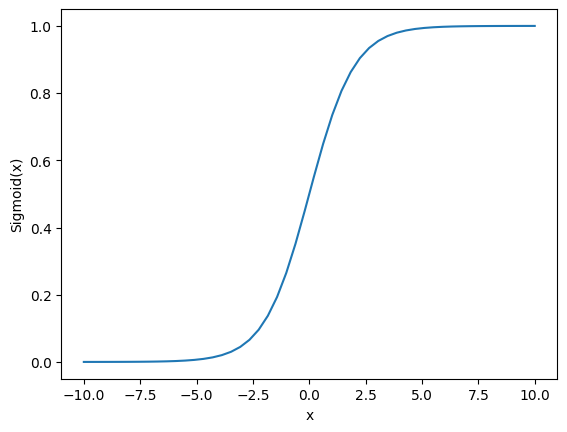

In [65]:
def sig(x):
 return 1/(1 + np.exp(-x))

x = np.linspace(-10, 10, 50)   
p = sig(x)
plt.xlabel("x") 
plt.ylabel("Sigmoid(x)")  
plt.plot(x, p) 
plt.show()